In [161]:
import math
import matplotlib.pyplot as plt

In [201]:
# sta_amount: Total contend stations number
# RA_RU: RA_RU number reserved for UORA
# Lmax: Retransmit limit
# TXOP: Transaction Opportunity (time length in ms)
# ocw_min: minimum OCW
# ocw_max: maximum OCW
def analytical(sta_amount, RA_RU, Lmax, TXOP, ocw_min, ocw_max, mode='general'):
    access_delay=0
    counter_delay_slot=0
    success_sta=0
    success_packet=0
    success_probability=0
    # setting ocw for each transmission [ocw_min, 1st_retry_ocw...ocw_max]
    ocw = [0 for _ in range(0, Lmax+1) ]
    ocw[1] = ocw_min
    for n in range (2, Lmax+1):
        temp_ocw = ocw[n-1] * 2 + 1
        if temp_ocw <= ocw_max:
            ocw[n] = temp_ocw
        else:
            ocw[n] = ocw[n-1]
    # Imax: Reserved slot for transmission (total slots in worst case)
    Imax = 0
    for z in range(1,Lmax+1):
        Imax += math.ceil(ocw[z] / RA_RU)
    # Ri: RA_RU number i-th slot, (Ri[i])
    Ri = [RA_RU for _ in range(0,Imax+1)]
    # M: Arrival number for i-th slot, (M[i])
    M  = [0 for _ in range(0,Imax+1)]
    # M_i: Arrival number for i-th slot and n-th transmission (M_i[n])
    M_i    = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Success stations for i-th slot and n-th transmission (M_i_s[n])
    M_i_s  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Fail stations for i-th slot and n-th transmission (M_i_s[n])
    M_i_f  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Success stations for i-th slot (M_i_s_C[i])
    M_i_s_C = [0 for _ in range(0,Imax+1)]

    
    for i in range (1,Imax+1):
        # calculate Mi[n], a_k_i
        for n in range (1, Lmax+1):
            # a_k_i: the portion of STAs that fail their (n − 1)th packet transmissions in the kth 
            # slot and transmit the packet for the nth time in the ith slot (k < i)
            if n == 1:
                if i == 1:
                    M_i[i][n] = min((Ri[i]+1) / (ocw[n]+1), 1) * sta_amount
                elif i >= 2 and i <= math.floor(ocw[n] / Ri[i]):
                    M_i[i][n] = Ri[i] / (ocw[n] + 1) * sta_amount
                elif i == math.ceil(ocw[n] / Ri[i]):
                    M_i[i][n] = (ocw[n] - Ri[i] * math.floor(ocw[n] / Ri[i])) / (ocw[n] + 1) * sta_amount
                else:
                    M_i[i][n] = 0
            elif n <= i:
                #/** Mi[n]=sigma (a_j_i*Mi_F[n-1]) */ 
                for k in range (1, i):
                    if ocw[n] <= Ri[i]:
                        if k == i-1:
                            a_k_i = 1
                        else:
                            a_k_i = 0
                    elif ocw[n] > Ri[i]:
                        if k == (i - math.ceil(ocw[n] / Ri[i])):
                            a_k_i = (ocw[n] - Ri[i] * (math.ceil(ocw[n] / Ri[i]) - 1)) / (ocw[n] + 1)
                        elif k <= (i-2) and k >= (i - math.ceil(ocw[n] / Ri[i]) + 1):
                            a_k_i = Ri[i] / (ocw[n] + 1)
                        elif k == (i - 1):
                            a_k_i = (Ri[i] + 1) / (ocw[n] + 1)
                        else:
                            a_k_i = 0
                    
                    M_i[i][n] += a_k_i * M_i_f[k][n-1]
            M[i] += M_i[i][n]
            
        #/** statistics */  
        for n in range (1,Lmax+1) : # n=1;n<=Lmax;n++){
            if Ri[i] != 0: #avoid Ri=0
                if mode == 'general':
                    M_i_s[i][n] = M_i[i][n] * math.exp(-M[i] / Ri[i])
#                     M_i_s[i][n] = M_i[i][n] * (1 - 1 / Ri[i]) ** (M[i] - 1)
                elif mode == 'power-ramping':
                    if M[i] != 0:
#                         M_i_s[i][n] = M_i[i][n] * ((1-1/Ri[i]) ** (M[i]-1)) + M_i[i][n] * (M[i]-1) / (2 * Ri[i]) * ((1-1/Ri[i]) ** (M[i]-2))
                        M_i_s[i][n] = M_i[i][n] * math.exp(-M[i] / Ri[i]) + M_i[i][n] * (M[i]-1) / (2 * Ri[i]) * math.exp(-M[i] / Ri[i])
    
            M_i_f[i][n] = M_i[i][n] - M_i_s[i][n]
            M_i_s_C[i] += M_i_s[i][n]


        #/** performance metric */  
        success_packet += M_i_s_C[i]
        success_sta += M_i_s_C[i]
        counter_delay_slot += M_i_s_C[i] * i
    
    #/** success probability */
    success_probability = success_packet / sta_amount
        
    access_delay = (TXOP * counter_delay_slot) / success_packet
#     Throughput 
    through_put = success_packet / Imax
#     Utilization
    utilization = success_packet / (Imax * RA_RU)
    # sta*success_probability 來算 grouping的Ds
    
    return Imax,success_probability,access_delay, utilization, through_put  # ,sta*success_probability

## Power-ramping

In [233]:
R = [9,18,37,74,148]
Lmax = 5
sta_max = 200
# sta_max = 500
m_list = [i for i in range(1, sta_max+1)]

ps_list = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_PR  = [ [0] * (sta_max) for _ in range(0, len(R))]

da_list = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]

u_list = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]

# for r in R:
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp = analytical(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=5.673, ocw_min=7, ocw_max=31)
        ps_list[idx][sta-1] = Ps
        da_list[idx][sta-1] = Da
        u_list[idx][sta-1] = U
        

for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp = analytical(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=5.673, ocw_min=7, ocw_max=31, mode='power-ramping')
        ps_list_PR[idx][sta-1] = Ps
        da_list_PR[idx][sta-1] = Da
        u_list_PR[idx][sta-1] = U

In [239]:
# Simulation (old -> m=200)

# m_list_simu = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
m_list_simu = [(i+1)*10 for i in range(20)]

ps_list_simu_9 = [1.0, 0.9999950000000001, 0.9993233333333319, 0.9823050000000445, 0.8935799999999517, 0.7351633333333306, 0.5755714285714284, 0.44921125000000256, 0.3576388888888865, 0.2906229999999992, 0.2398172727272715, 0.20437833333333197, 0.17633307692307906, 0.15383928571428812, 0.13691333333333933, 0.12320750000000014, 0.11175176470588485, 0.10230555555555793, 0.09459578947367968, 0.08800550000001081]
da_list_simu_9 = [9.321533220000067, 15.372281868157405, 23.053604067360773, 31.087004058696394, 38.02324270272845, 42.969863073429536, 46.656815686245366, 49.6880088326997, 52.52686462023924, 55.12554816371554, 57.39309137149707, 59.42806512086856, 61.26154943452731, 62.82330701108632, 64.18825478579275, 65.3030316552646, 66.33262932198312, 67.16256668744856, 67.84096119983691, 68.46583093117607]
t_list_simu_9 = [0.6666666666667462, 1.3333266666668258, 1.9986466666666638, 2.6194800000000678, 2.978600000000019, 2.9406533333333225, 2.6859999999999773, 2.3957933333333514, 2.1458333333333517, 1.9374866666666564, 1.7586599999999708, 1.6350266666666557, 1.5282199999999968, 1.4358333333333357, 1.3691333333333418, 1.3142133333333403, 1.2665200000000112, 1.2276666666666693, 1.1982133333333418, 1.1734066666666636]
u_list_simu_9 = [0.0740740740740585, 0.14814740740737628, 0.22207185185181538, 0.29105333333328515, 0.3309555555555469, 0.32673925925925074, 0.29844444444443713, 0.26619925925925847, 0.23842592592592723, 0.21527629629629477, 0.1954066666666632, 0.18166962962962604, 0.16980222222221986, 0.15953703703703567, 0.15212592592592358, 0.14602370370370252, 0.14072444444444288, 0.1364074074074066, 0.13313481481481348, 0.13037851851851692]

ps_list_simu_18 = [1.0, 1.0, 1.0, 0.99995, 0.9980800000000001, 0.9707166666666667, 0.8709571428571429, 0.7101875, 0.5575555555555556, 0.43478, 0.34472727272727277, 0.27919166666666667, 0.23003076923076923, 0.19190000000000002, 0.16332666666666665, 0.13916874999999998, 0.12301176470588236, 0.10768333333333334, 0.0971421052631579, 0.086925]
da_list_simu_18 = [7.153085700000049, 9.067155900000051, 11.731574899999988, 15.093529251923142, 19.09008126693999, 23.33233703008961, 26.8018308264839, 28.94852545343765, 30.532917745603132, 31.837506526209292, 33.18593160428127, 34.42601004723417, 35.631758514652645, 36.73415162068941, 37.80579065695904, 38.73824398417118, 39.5480863975717, 40.23293414487066, 40.92052939799466, 41.405369307131814]
[0.007159893300000028, 0.009118212900000026, 0.011682598000000004, 0.01502895392269617, 0.01913682602596985, 0.023362224971241203, 0.02673764262633881, 0.02889899989439409, 0.030475473575129475, 0.03194014605087625, 0.03318256186708865, 0.03438867853625049, 0.03557329925762441, 0.03684514888706919, 0.0377591767827258, 0.03869675412044727, 0.03943293836074978, 0.04021996904503944, 0.04091432638023514, 0.041348778947368436]
u_list_simu_18 = [0.06944444444444328, 0.13888888888888656, 0.2083333333333358, 0.2777638888888842, 0.3465555555555597, 0.40446527777777963, 0.42338194444444444, 0.39454861111111106, 0.34847222222222235, 0.30193055555555537, 0.2633333333333332, 0.2326597222222224, 0.20766666666666672, 0.18656944444444437, 0.1701319444444445, 0.15463194444444453, 0.14522222222222222, 0.13460416666666664, 0.1281736111111111, 0.12072916666666675]

ps_list_simu_37 = [1.0, 1.0, 1.0, 1.0, 1.0, 0.9999666666666667, 0.999528571428571, 0.9967874999999975, 0.9793888888888925, 0.9313000000000033, 0.8375363636363633, 0.7089916666666664, 0.5718230769230817, 0.451078571428572, 0.3452799999999998, 0.26574374999999967, 0.201094117647059, 0.15543888888888863, 0.11912631578947394, 0.09223499999999989]
da_list_simu_37 = [6.3758847000000145, 7.13011005000003, 8.067195100000005, 9.026168475000054, 10.096011180000016, 11.303854738135577, 12.721689776051768, 14.314263317119467, 15.941299751162035, 17.249969807700023, 18.152265802949284, 18.649688163752966, 18.81262240486881, 18.730165573227115, 18.636559100353026, 18.422278275440256, 18.287030454740925, 18.092741342836486, 17.94895240062306, 17.752785123480855]
t_list_simu_37 = [2.0, 4.0, 6.0, 8.0, 10.0, 11.9996, 13.993399999999994, 15.94859999999996, 17.62899999999993, 18.62600000000003, 18.42580000000001, 17.01580000000001, 14.867399999999995, 12.630199999999979, 10.35839999999999, 8.50379999999999, 6.837199999999999, 5.5958, 4.526799999999996, 3.689399999999997]
u_list_simu_37 = [0.05405405405405456, 0.10810810810810911, 0.16216216216216145, 0.21621621621621823, 0.27027027027026584, 0.32431351351351206, 0.37820000000000376, 0.43104324324324617, 0.4764594594594612, 0.5034054054054047, 0.49799459459459455, 0.4598864864864863, 0.40182162162162105, 0.34135675675675675, 0.2799567567567569, 0.2298324324324325, 0.1847891891891891, 0.1512378378378376, 0.12234594594594585, 0.09971351351351346]

ps_list_simu_74 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999833333333333, 0.9999230769230769, 0.9994928571428565, 0.9986733333333343, 0.9961124999999952, 0.9905529411764767, 0.9802499999999992, 0.9611210526315822, 0.9303399999999981]
da_list_simu_74 = [6.002601299999955, 6.452470200000017, 6.805709000000007, 7.207971975000036, 7.630525380000001, 8.07466455, 8.56007074285714, 9.051129675000045, 9.595186133333334, 10.139409630000014, 10.742753809090896, 11.380517106302504, 12.055478505366718, 12.790970892872318, 13.525396919489358, 14.351853771175621, 15.146230090821078, 15.924031075979928, 16.643472610078803, 17.27766554921806]
t_list_simu_74 = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 23.999599999999997, 25.997999999999994, 27.985799999999973, 29.96019999999993, 31.875599999999846, 33.67879999999984, 35.28899999999992, 36.522600000000054, 37.21359999999996]
u_list_simu_74 = [0.02702702702702728, 0.05405405405405456, 0.08108108108108072, 0.10810810810810911, 0.13513513513513292, 0.16216216216216145, 0.1891891891891912, 0.21621621621621823, 0.24324324324324892, 0.27027027027026584, 0.29729729729729265, 0.3243189189189175, 0.35132432432432703, 0.37818648648649, 0.4048675675675736, 0.43075135135135373, 0.4551189189189207, 0.47687837837837777, 0.4935486486486486, 0.5028864864864864]

ps_list_simu_148 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
da_list_simu_148 = [5.850564899999915, 6.025009650000004, 6.225172, 6.42481432500001, 6.630035100000024, 6.841070699999994, 7.025524242857132, 7.223998200000026, 7.428919566666663, 7.652706809999993, 7.875619609090933, 8.09735655000002, 8.319629053846148, 8.563271935714274, 8.845190320000002, 9.089386968750055, 9.332485447058815, 9.604735683333326, 9.896070773684217, 10.17974466000001]
t_list_simu_148 = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0, 32.0, 34.0, 36.0, 38.0, 40.0]
u_list_simu_148 = [0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12162162162162446, 0.13513513513513292, 0.14864864864864633, 0.16216216216216145, 0.17567567567567705, 0.1891891891891912, 0.2027027027027067, 0.21621621621621823, 0.22972972972973307, 0.24324324324324892, 0.25675675675675075, 0.27027027027026584]

In [240]:
# # m=500
# m_list_simu = [(i+1)*10 for i in range(50)]

# ps_list_simu_9 = [1.0, 1.0, 0.9993000000000003, 0.9815250000000043, 0.8967800000000012, 0.7374999999999992, 0.5734999999999998, 0.45079999999999987, 0.35788888888888826, 0.28983, 0.24054545454545453, 0.20251666666666648, 0.17604615384615468, 0.15304285714285706, 0.13630000000000025, 0.12346874999999988, 0.11252941176470627, 0.10165555555555546, 0.09437368421052612, 0.08712999999999967, 0.08253333333333379, 0.07703181818181823, 0.07287391304347823, 0.0687083333333334, 0.06432, 0.06109615384615405, 0.05794074074074071, 0.05517857142857129, 0.052882758620689536, 0.05093333333333341, 0.048548387096774205, 0.04665312499999996, 0.04536666666666662, 0.04342352941176492, 0.041468571428571306, 0.04016388888888892, 0.03873513513513499, 0.037221052631578884, 0.03660000000000039, 0.03434749999999999, 0.03431951219512179, 0.03269761904761928, 0.032025581395348855, 0.031065909090909057, 0.029935555555555618, 0.029091304347825947, 0.0289191489361703, 0.027808333333333324, 0.026963265306122353, 0.026197999999999902]
# da_list_simu_9 = [9.29634510000005, 15.464030700000057, 22.998055555418674, 31.028028145041525, 37.8924016493144, 42.93743783559382, 46.54914596965325, 49.77397749074821, 52.48655110415449, 54.961119162238276, 57.33712234577397, 59.449010719531586, 61.34167589676745, 62.91420487929284, 64.26034223043429, 65.3644013222207, 66.33007146303487, 67.11934215504392, 67.88033672879402, 68.51402725516263, 69.0788235109743, 69.41960941266088, 69.9083020221515, 70.37387608706563, 70.59979363178162, 70.98887248311254, 71.26672985882414, 71.56461623417178, 71.738228872431, 72.01531102255998, 72.20790624499696, 72.43867665164629, 72.66642013586987, 72.84833307141506, 72.96705489926964, 73.15353564436454, 73.34323527875182, 73.50185105616607, 73.69785424445465, 73.73070782473394, 73.95732169742381, 74.12535512845665, 74.17202286900735, 74.35198347861946, 74.48324678301626, 74.59865490899068, 74.70315148938079, 74.85159152051493, 74.89252581911217, 74.93887731247032]
# t_list_simu_9 = [0.6666666666666636, 1.3333333333333273, 1.9986000000000006, 2.617399999999983, 2.9892666666666647, 2.9499999999999966, 2.676333333333331, 2.404266666666667, 2.1473333333333344, 1.9321999999999975, 1.7639999999999982, 1.6201333333333319, 1.525733333333334, 1.4284000000000008, 1.363000000000003, 1.3170000000000028, 1.275333333333336, 1.2198666666666664, 1.195400000000002, 1.1617333333333373, 1.1554666666666675, 1.1298000000000012, 1.117400000000001, 1.0993333333333344, 1.072000000000003, 1.0590000000000013, 1.042933333333334, 1.0300000000000007, 1.0224000000000009, 1.0186666666666664, 1.003333333333334, 0.9952666666666675, 0.9980666666666671, 0.9842666666666661, 0.9676000000000008, 0.9639333333333326, 0.9554666666666655, 0.9429333333333311, 0.9515999999999991, 0.9159333333333323, 0.9380666666666672, 0.9155333333333331, 0.9180666666666663, 0.9112666666666659, 0.8980666666666663, 0.8921333333333329, 0.9061333333333325, 0.8898666666666664, 0.880799999999999, 0.8732666666666653]
# u_list_simu_9 = [0.074074074074075, 0.14814814814815, 0.22206666666667088, 0.2908222222222245, 0.33214074074073957, 0.3277777777777773, 0.2973703703703694, 0.26714074074074073, 0.23859259259259272, 0.21468888888888912, 0.19599999999999992, 0.1800148148148148, 0.16952592592592544, 0.15871111111111103, 0.15144444444444397, 0.14633333333333337, 0.14170370370370355, 0.13554074074074074, 0.13282222222222242, 0.1290814814814815, 0.1283851851851854, 0.12553333333333364, 0.12415555555555587, 0.12214814814814848, 0.1191111111111114, 0.11766666666666666, 0.11588148148148142, 0.1144444444444446, 0.11360000000000008, 0.1131851851851853, 0.11148148148148158, 0.11058518518518538, 0.11089629629629624, 0.10936296296296304, 0.10751111111111122, 0.10710370370370385, 0.10616296296296303, 0.10477037037037033, 0.10573333333333348, 0.1017703703703704, 0.1042296296296298, 0.10172592592592589, 0.10200740740740741, 0.10125185185185177, 0.0997851851851853, 0.09912592592592605, 0.10068148148148154, 0.0988740740740739, 0.09786666666666663, 0.09702962962962973]

# ps_list_simu_18 = [1.0, 1.0, 1.0, 0.9999250000000001, 0.997920000000001, 0.972633333333337, 0.8693142857142868, 0.717000000000001, 0.559844444444445, 0.4363, 0.34750909090909193, 0.2799500000000001, 0.22795384615384526, 0.1928785714285707, 0.16412666666666678, 0.14173124999999992, 0.12245882352941206, 0.10886111111111094, 0.09624210526315773, 0.08730999999999974, 0.07918095238095282, 0.07297272727272718, 0.06677826086956516, 0.06153333333333334, 0.05804799999999984, 0.05361153846153863, 0.049862962962963046, 0.04691785714285701, 0.044806896551724144, 0.042466666666666736, 0.04074193548387102, 0.038653125000000045, 0.03675454545454549, 0.03528823529411786, 0.03404000000000006, 0.03272222222222236, 0.03166216216216246, 0.0302105263157895, 0.029330769230769566, 0.02815249999999999, 0.026963414634146147, 0.02654523809523833, 0.025486046511627797, 0.02435227272727273, 0.02397555555555559, 0.02317173913043453, 0.02233191489361697, 0.021968750000000047, 0.02095714285714271, 0.020331999999999864]
# da_list_simu_18 = [7.117913100000048, 9.100059300000046, 11.680139699999994, 15.01772197115392, 19.09451621969495, 23.311574378805606, 26.72737148109471, 28.85759049311017, 30.464816643627604, 31.928791714432307, 33.18022099103646, 34.43874498553099, 35.60756541837234, 36.81176146725881, 37.78173196282733, 38.65445131016359, 39.64002329250163, 40.2919018321035, 40.81032437432215, 41.48090457373057, 41.9778351971861, 42.3702665816063, 42.72414984734641, 43.038337927840715, 43.259235312691985, 43.52778037059807, 43.796664682035, 43.934668197058585, 44.08011202681139, 44.295825606347755, 44.40921798614488, 44.503948063130295, 44.568744801717685, 44.65700393198354, 44.762648506530574, 44.8284215226384, 44.86446984938043, 44.9185238728496, 44.958834542857275, 45.01444987251406, 45.08523428930911, 45.10658264956332, 45.12868425242894, 45.18363232494446, 45.17900996183675, 45.1894795347686, 45.232995699990866, 45.232469436294785, 45.250502894398366, 45.272082120574375]
# t_list_simu_18 = [1.25, 2.5, 3.75, 4.999625, 6.237, 7.29475, 7.6065, 7.17, 6.29825, 5.45375, 4.77825, 4.19925, 3.70425, 3.375375, 3.077375, 2.834625, 2.60225, 2.449375, 2.28575, 2.18275, 2.0785, 2.00675, 1.919875, 1.846, 1.814, 1.742375, 1.682875, 1.642125, 1.62425, 1.5925, 1.57875, 1.546125, 1.516125, 1.49975, 1.48925, 1.4725, 1.464375, 1.435, 1.429875, 1.407625, 1.381875, 1.393625, 1.369875, 1.339375, 1.348625, 1.332375, 1.312, 1.318125, 1.283625, 1.27075]
# u_list_simu_18 = [0.06944444444444328, 0.13888888888888656, 0.2083333333333358, 0.27775694444443977, 0.34650000000000425, 0.40526388888889087, 0.42258333333333353, 0.39833333333333276, 0.34990277777777784, 0.3029861111111112, 0.2654583333333334, 0.23329166666666637, 0.2057916666666664, 0.18752083333333325, 0.17096527777777787, 0.15747916666666642, 0.14456944444444456, 0.13607638888888907, 0.1269861111111113, 0.12126388888888898, 0.1154722222222225, 0.11148611111111116, 0.10665972222222234, 0.1025555555555558, 0.10077777777777795, 0.09679861111111124, 0.09349305555555552, 0.0912291666666665, 0.09023611111111099, 0.08847222222222201, 0.08770833333333312, 0.08589583333333312, 0.08422916666666633, 0.08331944444444415, 0.08273611111111079, 0.08180555555555524, 0.08135416666666628, 0.07972222222222189, 0.07943749999999966, 0.07820138888888843, 0.07677083333333297, 0.0774236111111107, 0.07610416666666628, 0.07440972222222188, 0.07492361111111075, 0.07402083333333306, 0.07288888888888863, 0.07322916666666628, 0.07131249999999983, 0.070597222222222]

# # ps_list_simu_37 = [1.0, 1.0, 1.0, 1.0, 1.0, 0.99995, 0.9996714285714283, 0.9962874999999979, 0.9809888888888919, 0.9315100000000027, 0.8386363636363643, 0.709350000000001, 0.5718692307692357, 0.4490428571428576, 0.34750666666666613, 0.26503124999999994, 0.20398235294117648, 0.15686666666666665, 0.12017894736842126, 0.09223999999999971, 0.0708476190476195, 0.055027272727272654, 0.041965217391303995, 0.03318750000000005, 0.026075999999999794, 0.01954615384615405, 0.015581481481481429, 0.012121428571428679, 0.00944137931034478, 0.00739999999999997, 0.005509677419354848, 0.004481249999999977, 0.0035454545454545153, 0.002599999999999992, 0.0020171428571428692, 0.001661111111111106, 0.0013270270270270184, 0.0009921052631578972, 0.0007461538461538443, 0.0006099999999999986, 0.0004634146341463418, 0.0003999999999999993, 0.00028604651162790636, 0.00023409090909090857, 0.00015555555555555545, 0.00014347826086956518, 8.510638297872348e-05, 4.9999999999999996e-05, 7.75510204081632e-05, 4.200000000000002e-05]
# # da_list_simu_37 = [6.356029200000013, 7.185138150000028, 8.05490360000001, 9.046874925000052, 10.110760979999995, 11.363214510169454, 12.750003660613807, 14.249905157092817, 15.927432027233735, 17.285027549075345, 18.20085513343739, 18.651106375125153, 18.820628981751646, 18.752481284772628, 18.62322588007431, 18.465926940812004, 18.262492786615038, 18.034349488942073, 17.983660721662357, 17.74090412435411, 17.777879317258638, 17.446006102818544, 17.49970970853907, 17.360492223296323, 17.3365587848152, 17.248418655783645, 17.302224519401577, 17.03476472210583, 17.421706231739137, 17.24113473919168, 16.862850476764844, 17.083564507422327, 17.005591593567196, 16.784584991708044, 17.031074165029384, 17.259920673076845, 16.99397980501384, 17.047881832797348, 17.067201960784253, 17.261197044334917, 18.017027777777724, 16.879955882352924, 17.181085714285718, 16.66842134831461, 16.9200523255814, 18.0679140625, 16.37434090909091, 19.099100000000004, 17.505257142857147, 18.1536]
# # t_list_simu_37 = [2.0, 4.0, 6.0, 8.0, 10.0, 11.9994, 13.9954, 15.940599999999966, 17.65779999999995, 18.630199999999995, 18.450000000000006, 17.02439999999998, 14.868599999999994, 12.57320000000001, 10.425199999999998, 8.480999999999998, 6.9353999999999925, 5.647200000000004, 4.566799999999996, 3.6895999999999995, 2.975600000000006, 2.421200000000003, 1.9304000000000014, 1.592999999999998, 1.3038000000000003, 1.0163999999999993, 0.8414000000000003, 0.678800000000002, 0.547599999999999, 0.44399999999999845, 0.3415999999999983, 0.2867999999999985, 0.23399999999999913, 0.17679999999999957, 0.14120000000000052, 0.11960000000000087, 0.09820000000000059, 0.07540000000000038, 0.05820000000000016, 0.04880000000000008, 0.038, 0.03359999999999994, 0.02459999999999995, 0.020599999999999966, 0.013999999999999988, 0.013199999999999984, 0.008000000000000004, 0.004800000000000001, 0.007600000000000004, 0.0042000000000000015]
# # u_list_simu_37 = [0.05405405405405456, 0.10810810810810911, 0.16216216216216145, 0.21621621621621823, 0.27027027027026584, 0.3243081081081067, 0.378254054054058, 0.43082702702702974, 0.4772378378378406, 0.5035189189189185, 0.4986486486486486, 0.4601189189189184, 0.40185405405405367, 0.33981621621621577, 0.2817621621621626, 0.22921621621621582, 0.1874432432432432, 0.15262702702702693, 0.12342702702702706, 0.0997189189189189, 0.0804216216216213, 0.06543783783783814, 0.05217297297297324, 0.04305405405405409, 0.03523783783783785, 0.027470270270270346, 0.02274054054054056, 0.018345945945945925, 0.014800000000000058, 0.012000000000000044, 0.009232432432432493, 0.007751351351351393, 0.0063243243243243505, 0.004778378378378378, 0.00381621621621619, 0.003232432432432411, 0.0026540540540540367, 0.002037837837837826, 0.0015729729729729654, 0.0013189189189189144, 0.0010270270270270232, 0.0009081081081081053, 0.0006648648648648639, 0.0005567567567567564, 0.0003783783783783784, 0.00035675675675675677, 0.00021621621621621624, 0.00012972972972972974, 0.00020540540540540543, 0.00011351351351351351]
# ps_list_simu_37 = [1.0, 1.0, 1.0, 1.0, 1.0, 0.9999700000000002, 0.9995685714285762, 0.9961025, 0.979975555555615, 0.9315659999999618, 0.8373509090908959, 0.7082491666666658, 0.5722469230769011, 0.4486642857142827, 0.3459406666667135, 0.26553312500000037, 0.20298058823531673, 0.15565166666666666, 0.11950157894736388, 0.09205050000000993, 0.07118000000000198, 0.05494727272727386, 0.04272652173913384, 0.0328704166666668, 0.02543680000000066, 0.01993846153846441, 0.015491851851852078, 0.011848571428571803, 0.009309655172414895, 0.007226666666666317, 0.005624516129032019, 0.004381874999999978, 0.003514545454545686, 0.0026605882352944473, 0.0020651428571428735, 0.0016105555555556944, 0.0012351351351350865, 0.0009471052631579017, 0.000764615384615382, 0.0005872500000000154, 0.0004680487804877946, 0.0003473809523809512, 0.00027348837209302155, 0.00020636363636363476, 0.0001617777777777757, 0.0001345652173913053, 9.574468085106278e-05, 8.291666666666644e-05, 6.0000000000000374e-05, 4.7200000000000036e-05]
# da_list_simu_37 = [6.371856869999976, 7.1884001250000145, 8.050308470000049, 9.027473264999706, 10.114039974000052, 11.350362921610143, 12.737961036101511, 14.295736590521686, 15.888781644013186, 17.25014717426593, 18.17585677274479, 18.649736450556084, 18.802111391359173, 18.77660163778526, 18.612060267763365, 18.440018870146787, 18.256150850371007, 18.07467162092382, 17.901809237697098, 17.76918228323108, 17.65173110229681, 17.554868189932492, 17.47868247872004, 17.371541514860034, 17.333423755845097, 17.31438734839929, 17.239209467889445, 17.244913918105173, 17.185328027774077, 17.111138388555492, 17.14384463833864, 17.13507148802465, 17.16918935385968, 16.871646045897034, 17.02700462135942, 16.947069104308525, 17.187602254319778, 17.284921875000148, 17.084156407278446, 16.79647641734161, 16.71012229190427, 16.782798677443083, 16.703833333333264, 17.40002238805959, 17.09142127659564, 16.81537813021692, 16.917696428571332, 16.741198453608156, 17.038562068965437, 17.4733311688311]
# t_list_simu_37 = [2.0, 4.0, 6.0, 8.0, 10.0, 11.999640000000005, 13.993960000000035, 15.93764, 17.639559999999864, 18.631320000000073, 18.42171999999999, 16.997979999999934, 14.878420000000002, 12.562600000000026, 10.378220000000026, 8.497060000000012, 6.901339999999972, 5.603459999999995, 4.541060000000011, 3.6820199999999925, 2.9895600000000133, 2.4176800000000003, 1.9654200000000062, 1.5777799999999986, 1.2718400000000023, 1.0367999999999982, 0.8365600000000104, 0.6635200000000029, 0.5399599999999918, 0.43359999999998927, 0.3487199999999926, 0.2804399999999986, 0.2319600000000079, 0.18092000000001435, 0.14456000000001068, 0.11596000000000686, 0.09140000000000392, 0.07198000000000135, 0.05963999999999944, 0.04697999999999841, 0.038379999999998846, 0.0291799999999993, 0.023519999999999593, 0.018159999999999853, 0.014560000000000028, 0.012380000000000118, 0.009000000000000072, 0.007960000000000056, 0.005880000000000029, 0.004720000000000012]
# u_list_simu_37 = [0.05405405405406058, 0.10810810810812116, 0.16216216216214344, 0.21621621621624232, 0.27027027027029066, 0.3243145945945571, 0.37821513513509525, 0.4307470270270749, 0.47674486486488676, 0.5035491891891801, 0.4978843243243233, 0.4594048648648653, 0.4021194594594579, 0.3395297297297289, 0.2804924324324334, 0.2296502702702707, 0.1865227027026981, 0.15144486486486372, 0.12273135135135378, 0.09951405405405407, 0.08079891891891935, 0.06534270270270294, 0.05311945945945864, 0.04264270270270219, 0.034374054054054616, 0.028021621621622268, 0.02260972972973055, 0.017932972972973957, 0.014593513513514475, 0.011718918918919729, 0.009424864864865344, 0.007579459459459488, 0.00626918918918879, 0.004889729729729443, 0.003907027027026822, 0.0031340540540539057, 0.002470270270270173, 0.0019454054054053526, 0.0016118918918918677, 0.00126972972972972, 0.0010372972972973005, 0.0007886486486486691, 0.0006356756756756868, 0.0004908108108108131, 0.00039351351351351005, 0.00033459459459459173, 0.00024324324324324128, 0.00021513513513513356, 0.00015891891891891784, 0.0001275675675675668]

# ps_list_simu_74 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999833333333333, 0.999876923076923, 0.9996499999999995, 0.9988800000000008, 0.9963062499999951, 0.9902294117647125, 0.9795444444444453, 0.9603421052631621, 0.9311499999999996, 0.8892904761904774, 0.8364181818181848, 0.7746999999999986, 0.7075249999999996, 0.6397680000000011, 0.5726384615384658, 0.5097925925925919, 0.451025, 0.397724137931031, 0.34934333333333334, 0.307535483870968, 0.26901562500000004, 0.23474545454545429, 0.20489117647058755, 0.1791057142857135, 0.15784722222222225, 0.13856756756756763, 0.12068947368421057, 0.10509487179487205, 0.09418749999999992, 0.08280975609756078, 0.07223333333333343, 0.06393255813953495, 0.056340909090909164, 0.049097777777777823, 0.04332608695652142, 0.03827659574468088, 0.033689583333333356, 0.029457142857142852, 0.0262179999999999]
# da_list_simu_74 = [6.017918399999953, 6.408504450000018, 6.825186299999992, 7.231656750000032, 7.651628939999994, 8.082890400000014, 8.567931899999992, 9.080771100000064, 9.571989866666678, 10.132431840000006, 10.748426809090903, 11.385765823109224, 12.090415322361356, 12.810056599710387, 13.549109309569708, 14.360841551402254, 15.124088425010347, 15.925866328201012, 16.652852881981147, 17.242958682621968, 17.7326751980873, 18.170914566706056, 18.450841272358797, 18.64822110193848, 18.73950389486853, 18.811502941501676, 18.779974707024717, 18.77123769870105, 18.679600421737312, 18.618222684011222, 18.515504340949104, 18.426328753683634, 18.314482473915714, 18.240487783712336, 18.153055843121493, 18.063691145198945, 17.988212834254977, 17.932516409265496, 17.824906033519664, 17.71092807698146, 17.748656030045655, 17.690872554971634, 17.587842249001277, 17.525271696239887, 17.466310526504934, 17.438258252926, 17.38962907004231, 17.392260495410056, 17.29096831853824, 17.360836363419754]
# t_list_simu_74 = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 23.999599999999997, 25.996799999999993, 27.99019999999998, 29.966399999999936, 31.881799999999842, 33.66779999999983, 35.26359999999995, 36.492999999999974, 37.24600000000001, 37.35019999999998, 36.80240000000001, 35.6362, 33.96119999999997, 31.9884, 29.777199999999986, 27.528800000000025, 25.257400000000022, 23.067999999999987, 20.960600000000014, 19.06720000000002, 17.217000000000002, 15.493200000000003, 13.932599999999995, 12.537400000000009, 11.365000000000013, 10.25399999999998, 9.1724, 8.197400000000002, 7.535000000000001, 6.790400000000001, 6.067599999999997, 5.498200000000003, 4.957999999999999, 4.418799999999999, 3.9859999999999998, 3.597999999999997, 3.2341999999999973, 2.886800000000004, 2.6218000000000012]
# u_list_simu_74 = [0.02702702702702728, 0.05405405405405456, 0.08108108108108072, 0.10810810810810911, 0.13513513513513292, 0.16216216216216145, 0.1891891891891912, 0.21621621621621823, 0.24324324324324892, 0.27027027027026584, 0.29729729729729265, 0.32431891891891745, 0.3513081081081108, 0.37824594594594946, 0.4049513513513576, 0.43083513513513716, 0.4549702702702722, 0.476535135135134, 0.4931486486486493, 0.5033243243243237, 0.5047324324324324, 0.4973297297297294, 0.4815702702702699, 0.4589351351351341, 0.43227567567567493, 0.40239459459459415, 0.3720108108108102, 0.3413162162162157, 0.31172972972972973, 0.28325135135135165, 0.2576648648648656, 0.232662162162162, 0.20936756756756733, 0.18827837837837794, 0.16942432432432405, 0.153581081081081, 0.13856756756756763, 0.12395135135135145, 0.11077567567567566, 0.10182432432432423, 0.09176216216216213, 0.0819945945945946, 0.07429999999999998, 0.06699999999999996, 0.05971351351351344, 0.053864864864864866, 0.04862162162162161, 0.04370540540540535, 0.039010810810810724, 0.035429729729729756]

# ps_list_simu_148 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999954545454546, 0.9999956521739131, 0.9999791666666665, 0.9999759999999999, 0.9999000000000007, 0.9997962962962974, 0.999667857142859, 0.999358620689655, 0.9988033333333343, 0.9979419354838727, 0.9964312500000043, 0.9941696969697015, 0.9911205882353006, 0.9863600000000053, 0.9796722222222253, 0.9713540540540574, 0.9603394736842132, 0.9473999999999948, 0.9302874999999989, 0.9102024390243819, 0.8870547619047632, 0.861374418604652, 0.8358840909090959, 0.8050844444444433, 0.773519565217394, 0.741017021276596, 0.7075145833333337, 0.6725653061224499, 0.638946]
# da_list_simu_148 = [5.847728399999921, 6.030398999999995, 6.231979600000006, 6.425523450000017, 6.626290920000028, 6.834830399999986, 7.035978771428548, 7.250944950000032, 7.4547002, 7.671314249999992, 7.90037451818183, 8.102084050000013, 8.334815238461545, 8.573321249999992, 8.82802003999999, 9.083217581250034, 9.354476664705892, 9.601048233333318, 9.885083068421062, 10.17288033000002, 10.477166542857137, 10.76384646581569, 11.069453474900321, 11.434627471077398, 11.717005998072251, 12.098466705183519, 12.447780328291506, 12.79080093082126, 13.169049286292926, 13.563740687209059, 13.952779204464559, 14.354557804491966, 14.770784323800099, 15.15943313348371, 15.51761687610691, 15.938979355032279, 16.274721968015395, 16.63309793398833, 16.964881668591342, 17.264890885238163, 17.549223664874507, 17.773443297233758, 17.97874906128496, 18.16444710334881, 18.340071969812506, 18.441699291360752, 18.557801608689502, 18.64277023402241, 18.683965058504214, 18.7295841501786]
# t_list_simu_148 = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0, 32.0, 34.0, 36.0, 38.0, 40.0, 42.0, 43.9998, 45.9998, 47.99900000000001, 49.9988, 51.99480000000002, 53.98900000000004, 55.98140000000006, 57.96280000000014, 59.92820000000022, 61.87240000000027, 63.77160000000028, 65.61520000000016, 67.39620000000004, 69.04519999999997, 70.5363999999999, 71.88020000000006, 72.98579999999997, 73.89719999999998, 74.42300000000002, 74.63660000000006, 74.51260000000008, 74.07820000000001, 73.55780000000004, 72.45760000000007, 71.16380000000002, 69.65559999999995, 67.9214, 65.91140000000001, 63.894600000000054]
# u_list_simu_148 = [0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12162162162162446, 0.13513513513513292, 0.14864864864864633, 0.16216216216216145, 0.17567567567567705, 0.1891891891891912, 0.2027027027027067, 0.21621621621621823, 0.22972972972973307, 0.24324324324324892, 0.25675675675675075, 0.27027027027026584, 0.283783783783783, 0.2972959459459413, 0.3108094594594617, 0.32431756756756613, 0.3378297297297236, 0.35131621621621895, 0.3647905405405363, 0.378252702702707, 0.3916405405405377, 0.4049202702702745, 0.4180567567567531, 0.4308891891891891, 0.44334594594594434, 0.45537972972973156, 0.4665216216216206, 0.4765972972972966, 0.4856770270270287, 0.4931472972972987, 0.49930540540540563, 0.5028581081081073, 0.5043013513513509, 0.5034635135135133, 0.5005283783783788, 0.49701216216216226, 0.4895783783783788, 0.48083648648648664, 0.4706459459459457, 0.4589283783783785, 0.4453472972972975, 0.43172027027027]

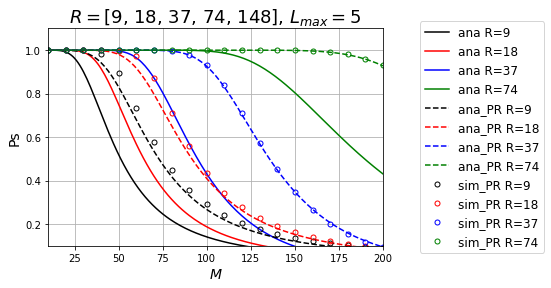

In [244]:
plt.plot(m_list, ps_list[0], color='black', label='ana R=9')
plt.plot(m_list, ps_list[1], color='red', label='ana R=18')
plt.plot(m_list, ps_list[2], color='blue', label='ana R=37')
plt.plot(m_list, ps_list[3], color='green', label='ana R=74')
# plt.plot(m_list, ps_list[4], color='orange', label='ana R=148')

plt.plot(m_list, ps_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, ps_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, ps_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, ps_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
# plt.plot(m_list, ps_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.plot(m_list_simu, ps_list_simu_9, label='sim_PR R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, ps_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, ps_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, ps_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
# plt.plot(m_list_simu, ps_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)


plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) , fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Ps", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
plt.axis([10,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

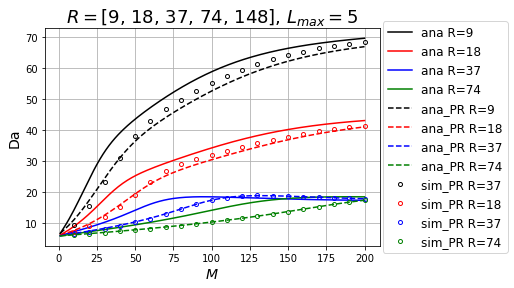

In [245]:
plt.plot(m_list, da_list[0], color='black', label='ana R=9')
plt.plot(m_list, da_list[1], color='red', label='ana R=18')
plt.plot(m_list, da_list[2], color='blue', label='ana R=37')
plt.plot(m_list, da_list[3], color='green', label='ana R=74')
# plt.plot(m_list, da_list[4], color='orange', label='ana R=148')

plt.plot(m_list, da_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, da_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, da_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, da_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
# plt.plot(m_list, da_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.plot(m_list_simu, da_list_simu_9, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=4)
plt.plot(m_list_simu, da_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=4)
plt.plot(m_list_simu, da_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=4)
plt.plot(m_list_simu, da_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=4)
# plt.plot(m_list_simu, da_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=4)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) , fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Da", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.4, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,60]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

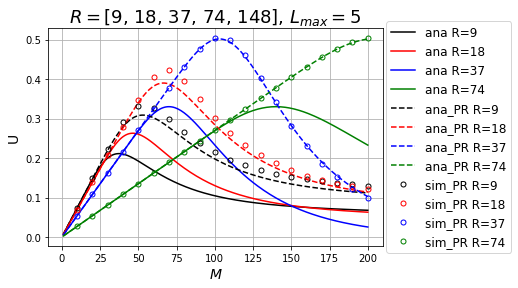

In [246]:
plt.plot(m_list, u_list[0], color='black', label='ana R=9')
plt.plot(m_list, u_list[1], color='red', label='ana R=18')
plt.plot(m_list, u_list[2], color='blue', label='ana R=37')
plt.plot(m_list, u_list[3], color='green', label='ana R=74')
# plt.plot(m_list, u_list[4], color='orange', label='ana R=148')

plt.plot(m_list, u_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, u_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, u_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, u_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
# plt.plot(m_list, u_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.plot(m_list_simu, u_list_simu_9, label='sim_PR R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, u_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, u_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, u_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
# plt.plot(m_list_simu, u_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) , fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("U", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.4, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,0.35]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()